In [215]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras import regularizers
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

import warnings
warnings.filterwarnings('ignore')

## Import data

In [3]:
data = pd.read_excel('steam_generator_data.xlsx')

data.head()

,time,fuel_in,air_in,level ref_in,disturb_in,P_out,Ex O2_out,Waterlevel_out,Steamflow_out
0,0,0.72,0.69,-2.28,0.02,320,2.51,0.03,9.30
1,3,0.53,0.38,-3.72,0.02,322,2.55,0.29,9.66
2,6,0.59,0.71,-1.53,0.02,321,2.36,0.20,11.00
3,9,0.37,0.71,-3.17,0.02,325,0.03,0.33,12.40
4,12,0.58,0.36,-1.80,0.02,327,0.29,0.75,13.70


## Explore data

In [20]:
varin = data[['fuel_in','air_in','level ref_in','disturb_in']]
varout = data[['P_out','Ex O2_out','Steamflow_out']]

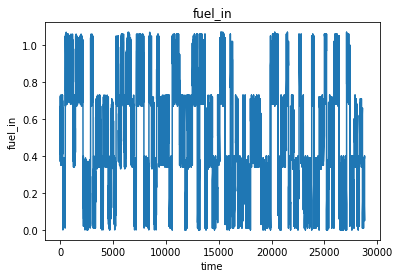

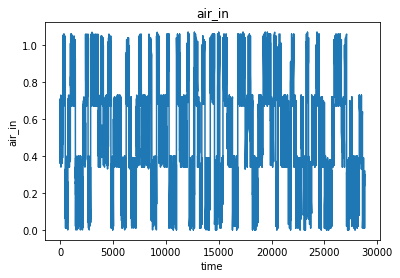

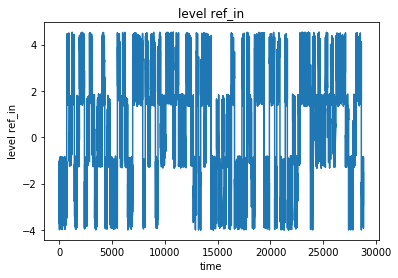

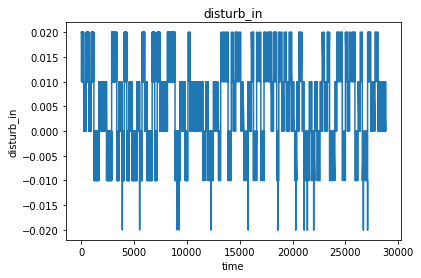

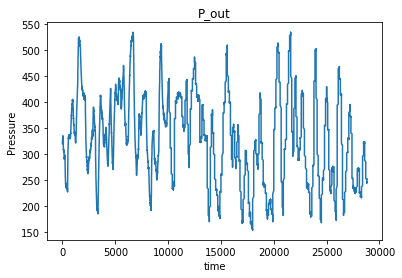

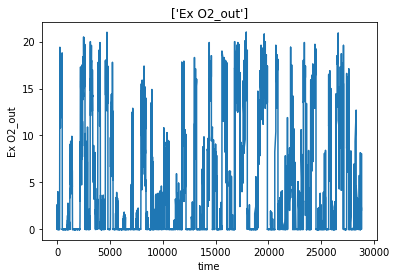

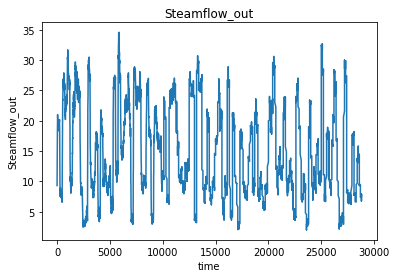

In [6]:
plt.plot(data['time'],varin['fuel_in'])
plt.xlabel('time')
plt.ylabel('fuel_in')
plt.title('fuel_in')
plt.show()

plt.plot(data['time'],varin['air_in'])
plt.xlabel('time')
plt.ylabel('air_in')
plt.title('air_in')
plt.show()

plt.plot(data['time'],varin['level ref_in'])
plt.xlabel('time')
plt.ylabel('level ref_in')
plt.title('level ref_in')
plt.show()

plt.plot(data['time'],varin['disturb_in'])
plt.xlabel('time')
plt.ylabel('disturb_in')
plt.title('disturb_in')
plt.show()

plt.plot(data['time'],varout['P_out'])
plt.xlabel('time')
plt.ylabel('Pressure')
plt.title('P_out')
plt.show()

plt.plot(data['time'],varout['Ex O2_out'])
plt.xlabel('time')
plt.ylabel('Ex O2_out')
plt.title(['Ex O2_out'])
plt.show()

plt.plot(data['time'],varout['Steamflow_out'])
plt.xlabel('time')
plt.ylabel('Steamflow_out')
plt.title('Steamflow_out')
plt.show()

In [7]:
varin.isnull().sum()

fuel_in         0
air_in          0
level ref_in    0
disturb_in      0
dtype: int64

In [8]:
varout.isnull().sum()

P_out            0
Ex O2_out        0
Steamflow_out    0
dtype: int64

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


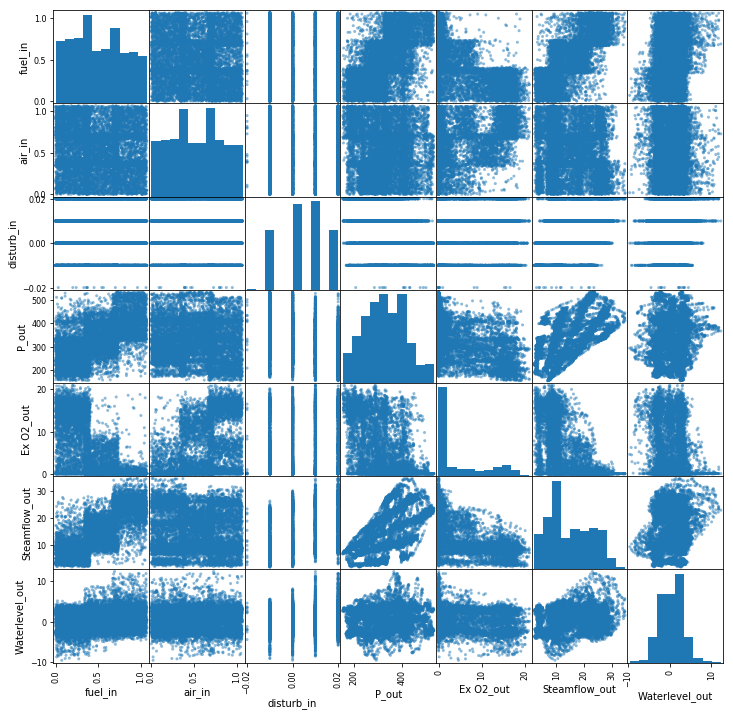

In [9]:
sm = pd.scatter_matrix(data[['fuel_in','air_in','disturb_in','P_out','Ex O2_out','Steamflow_out','Waterlevel_out']], figsize=(12,12))
plt.show()

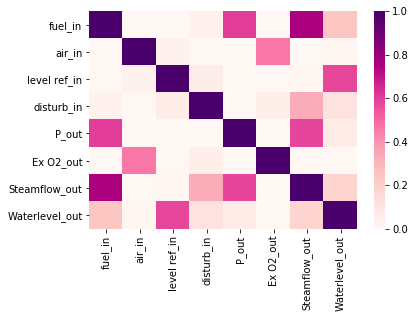

In [10]:
corr = data[['fuel_in',
             'air_in',
             'level ref_in',
             'disturb_in',
             'P_out',
             'Ex O2_out',
             'Steamflow_out',
             'Waterlevel_out']].corr()

heatmap = sns.heatmap(corr, vmin=0, vmax=1, cmap ='RdPu')

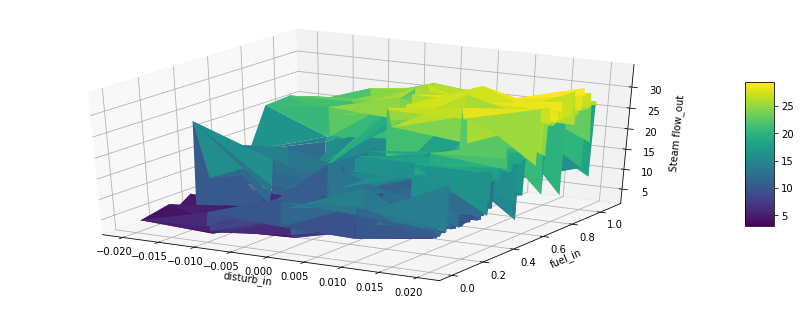

In [16]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,4))
ax = Axes3D(fig)
surf = ax.plot_trisurf(data['disturb_in'], data['fuel_in'], data['Steamflow_out'], cmap=plt.cm.viridis, linewidth=1)
ax.set_xlabel('disturb_in')
ax.set_ylabel('fuel_in')
ax.set_zlabel('Steam flow_out')
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

## Preparing training and testing data

In [150]:
X = varin[['fuel_in','disturb_in']]
y = varout['Steamflow_out']

In [151]:
n_steps = 1
def creat_batches(seq_X,seq_y, n_steps):
    X, y = list(), list()
    
    for i in range(len(seq_X)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(seq_X)-1:
            break
            
        # gather input and output parts of the pattern
        temp_seq_x = seq_X[i:end_ix]
        temp_seq_y = seq_y[end_ix]
        X.append(temp_seq_x)
        y.append(temp_seq_y)
    return np.array(X), np.array(y)

In [399]:
# Feature scaling
from sklearn.preprocessing import MinMaxScaler

n_features = 1

sc_x = MinMaxScaler()
sc_y = MinMaxScaler()

X_sc = sc_x.fit_transform(X)

y_sc = sc_y.fit_transform(y.values.reshape(-1,1))

In [400]:
X_sc_reshape = X_sc.reshape(X_sc.shape[0],X_sc.shape[1],n_features)
y_sc_reshape = y_sc.reshape(y_sc.shape[0],y_sc.shape[1],n_features)

In [401]:
train_size = int(0.7*len(X_sc_reshape))

X_train = X_sc_reshape[:train_size]
X_test = X_sc_reshape[train_size:]

y_train = y_sc_reshape[:train_size]
y_test = y_sc_reshape[train_size:]

## Building model

#### Encoder-Decoder model

In [404]:
X_train.shape

(6720, 2, 1)

In [407]:
model = Sequential()
model.add(LSTM(100,
               activation='relu',
               input_shape=(2,1)
              ))

model.add(RepeatVector(n_steps))       

# Decoder model
model.add(LSTM(100, activation='relu',return_sequences=True))

# Output
model.add(TimeDistributed(Dense(1)))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
          
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_51 (LSTM)               (None, 100)               40800     
_________________________________________________________________
repeat_vector_15 (RepeatVect (None, 1, 100)            0         
_________________________________________________________________
lstm_52 (LSTM)               (None, 1, 100)            80400     
_________________________________________________________________
time_distributed_12 (TimeDis (None, 1, 1)              101       
_________________________________________________________________
dense_41 (Dense)             (None, 1, 1)              2         
Total params: 121,303
Trainable params: 121,303
Non-trainable params: 0
_________________________________________________________________


In [408]:
model.fit(X_train,y_train, epochs=80, validation_data=(X_test,y_test),verbose=1)

Train on 6720 samples, validate on 2880 samples
Epoch 1/80
6720/6720 [==============================] - 10s 2ms/step - loss: 0.0427 - val_loss: 0.0177
Epoch 2/80
6720/6720 [==============================] - 4s 564us/step - loss: 0.0175 - val_loss: 0.0177
Epoch 3/80
6720/6720 [==============================] - 4s 600us/step - loss: 0.0172 - val_loss: 0.0173
Epoch 4/80
6720/6720 [==============================] - 5s 760us/step - loss: 0.0169 - val_loss: 0.0172
Epoch 5/80
6720/6720 [==============================] - 4s 639us/step - loss: 0.0168 - val_loss: 0.0175
Epoch 6/80
6720/6720 [==============================] - 5s 675us/step - loss: 0.0166 - val_loss: 0.0174
Epoch 7/80
6720/6720 [==============================] - 5s 701us/step - loss: 0.0164 - val_loss: 0.0178
Epoch 8/80
6720/6720 [==============================] - 4s 622us/step - loss: 0.0163 - val_loss: 0.0170
Epoch 9/80
6720/6720 [==============================] - 4s 614us/step - loss: 0.0164 - val_loss: 0.0172
Epoch 10/80
6720/

6720/6720 [==============================] - 4s 524us/step - loss: 0.0147 - val_loss: 0.0179
Epoch 79/80
6720/6720 [==============================] - 3s 503us/step - loss: 0.0148 - val_loss: 0.0172
Epoch 80/80
6720/6720 [==============================] - 4s 637us/step - loss: 0.0147 - val_loss: 0.0171


Text(0,0.5,'loss')

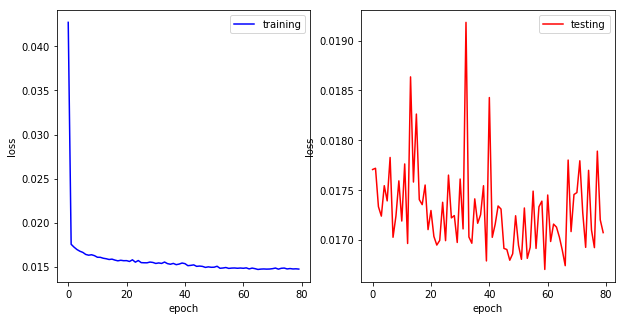

In [409]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(model.history.history['loss'],'b',label='training')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(122)
plt.plot(model.history.history['val_loss'],'r',label='testing')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

#### Vanilla model

In [345]:
n_features = 2

sc_x = MinMaxScaler()
sc_y = MinMaxScaler()

X_sc = sc_x.fit_transform(X)

y_sc = sc_y.fit_transform(y.values.reshape(-1,1))

In [346]:
print('dimension of X: ',X_sc.shape)
print('dimension of y: ',y_sc.shape)

dimension of X:  (9600, 2)
dimension of y:  (9600, 1)


In [385]:
X_sc_reshaped = X_sc.reshape(X_sc.shape[0],1,2)
#y_sc_reshaped = y_sc.reshape(y_sc.shape[0],1,1)

print('dimension of X after reshape: ',X_sc_reshaped.shape)

dimension of X after reshape:  (9600, 1, 2)


In [386]:
train_size = int(0.7*len(X_sc_reshaped))

X_train = X_sc_reshaped[:train_size]
X_test = X_sc_reshaped[train_size:]

y_train = y_sc[:train_size]
y_test = y_sc[train_size:]

In [387]:
model_v2 = Sequential()
model_v2.add(LSTM(100, 
                  activation='relu', 
                  input_shape=(X_train.shape[1],X_train.shape[2]),
                  kernel_regularizer=regularizers.l2(0.1),
                  activity_regularizer=regularizers.l1(0.0)))
model_v2.add(Dropout(0.1))
model_v2.add(Dense(1))
model_v2.compile(optimizer='adam', loss='mse')
model_v2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_48 (LSTM)               (None, 100)               41200     
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 101       
Total params: 41,301
Trainable params: 41,301
Non-trainable params: 0
_________________________________________________________________


In [388]:
model_v2.fit(X_train,y_train, batch_size = 10, epochs=80,validation_data=(X_test,y_test),verbose=1)

Train on 6720 samples, validate on 2880 samples
Epoch 1/80
6720/6720 [==============================] - 10s 2ms/step - loss: 0.0822 - val_loss: 0.0387
Epoch 2/80
6720/6720 [==============================] - 6s 832us/step - loss: 0.0347 - val_loss: 0.0304
Epoch 3/80
6720/6720 [==============================] - 5s 776us/step - loss: 0.0281 - val_loss: 0.0249
Epoch 4/80
6720/6720 [==============================] - 5s 672us/step - loss: 0.0259 - val_loss: 0.0229
Epoch 5/80
6720/6720 [==============================] - 5s 743us/step - loss: 0.0244 - val_loss: 0.0225
Epoch 6/80
6720/6720 [==============================] - 4s 662us/step - loss: 0.0236 - val_loss: 0.0215
Epoch 7/80
6720/6720 [==============================] - 5s 741us/step - loss: 0.0234 - val_loss: 0.0212
Epoch 8/80
6720/6720 [==============================] - 5s 805us/step - loss: 0.0231 - val_loss: 0.0214
Epoch 9/80
6720/6720 [==============================] - 5s 674us/step - loss: 0.0224 - val_loss: 0.0219
Epoch 10/80
6720/

Epoch 79/80
6720/6720 [==============================] - 6s 895us/step - loss: 0.0210 - val_loss: 0.0199
Epoch 80/80
6720/6720 [==============================] - 7s 1ms/step - loss: 0.0210 - val_loss: 0.0219


Text(0,0.5,'loss')

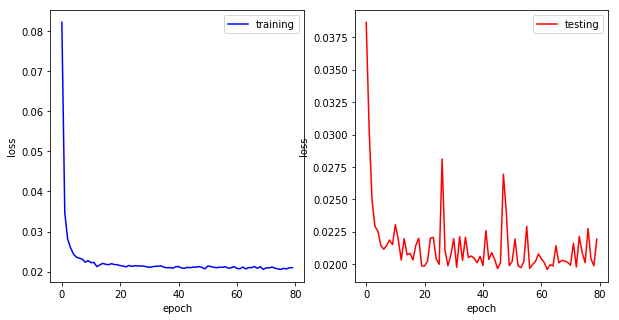

In [389]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(model_v2.history.history['loss'],'b',label='training')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(122)
plt.plot(model_v2.history.history['val_loss'],'r',label='testing')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

## Model Prediction

#### Encoder-decoder model

In [410]:
y_pred = model.predict(X_test,verbose=0)

In [411]:
rmse = np.sqrt(mean_squared_error(y_test.reshape(1,-1),y_pred.reshape(1,-1)))
print('RMSE is ',rmse)

RMSE is  0.13065982853096486


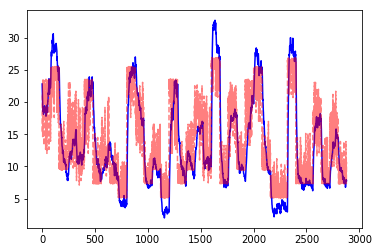

In [412]:
y_test = sc_y.inverse_transform(y_test.reshape(1,-1)).reshape(1,-1)[0]
y_pred = sc_y.inverse_transform(y_pred.reshape(1,-1)).reshape(1,-1)[0]

plt.figure()
plt.plot(y_test,'b',label='actual')
plt.plot(y_pred,'r',linestyle='dashed',alpha=0.5,label='prediction')
plt.show()

#### Vanilla model

In [390]:

y_pred = model_v2.predict(X_test,verbose=0)

In [391]:
rmse = np.sqrt(mean_squared_error(y_test.reshape(1,-1),y_pred.reshape(1,-1)))
print('RMSE is ',rmse)

RMSE is  0.14510642030069335


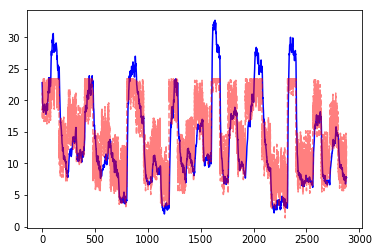

In [392]:
y_test = sc_y.inverse_transform(y_test.reshape(1,-1)).reshape(1,-1)[0]
y_pred = sc_y.inverse_transform(y_pred.reshape(1,-1)).reshape(1,-1)[0]

plt.figure()
plt.plot(y_test,'b',label='actual')
plt.plot(y_pred,'r',linestyle='dashed',alpha=0.5,label='prediction')
plt.show()